In [1]:
import numpy as np
import matplotlib.pyplot as plt
from ase.dft.kpoints import bandpath
from gpaw import restart
from ase.visualize import view

atoms, _ = restart("mos2_2H_bands.gpw") 
num_wann,nrpts = np.loadtxt("mos2_hr.dat", skiprows = 1, max_rows = 2, dtype = int)
data = np.loadtxt("mos2_hr.dat", skiprows = int(3 + np.ceil(nrpts/15)) ).T

wannier_centers = np.loadtxt("mos2_centres.xyz", skiprows=2, max_rows = num_wann, usecols = [1,2,3])

degens = []
with open("mos2_hr.dat") as f:
    for i, line in enumerate(f):
        if i >=3 and i < int(3 + np.ceil(nrpts/15)) :
            degens += line.split()

degens = np.array(degens, dtype = np.float64)

hamiltonian_R = np.array(data[5]).reshape(nrpts,num_wann,num_wann) + 1j*np.array(data[6]).reshape(nrpts,num_wann,num_wann)

R_frac = np.unique(np.vstack([data[0],data[1],data[2]]).T,axis = 0) # with respect to the lattice vectors {A_i}
assert R_frac.shape[0] == nrpts


In [2]:
view(atoms)

<Popen: returncode: None args: ['/usr/bin/python', '-m', 'ase', 'gui', '-']>

In [3]:
#index = R_frac[:,0] < 3
#R_frac = R_frac[index]
#hamiltonian_R = hamiltonian_R[index]

max imaginary energy: 8.739724368620186e-15


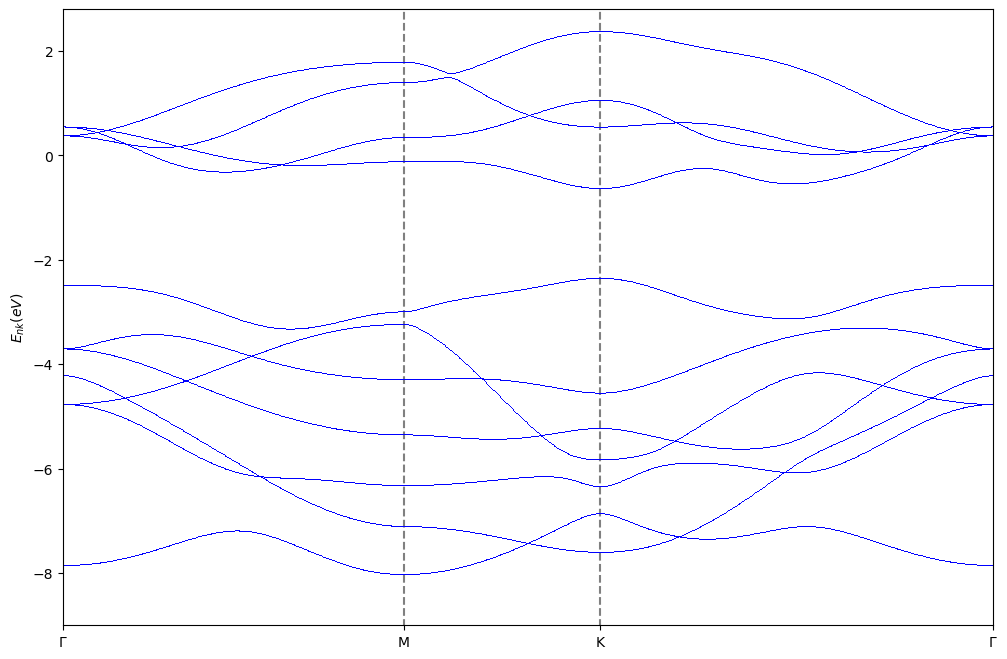

In [4]:
cell = atoms.cell
R_cart = np.dot(R_frac,cell) # Cartesian, Right
#R_cart = np.array([np.dot(cell,r) for r in R_frac]) # Cartesian, Wrong


bpath = bandpath(path = [[0,0,0],[0.5,0,0],[1/3,1/3,0],[0,0,0]], cell = atoms.cell, npoints = 1000, eps = 1e-6)
kpts = bpath.cartesian_kpts()
(linear_kpts,ticks,_) = bpath.get_linear_kpoint_axis(1e-6)

hamiltonian_k = np.zeros(shape = (len(kpts),num_wann,num_wann), dtype = complex)
hamiltonian_k_2 = np.zeros(shape = hamiltonian_k.shape, dtype = complex)

for i,kpt in enumerate(kpts):
    for j,R in enumerate(R_cart):
        hamiltonian_k[i,:,:] += np.exp(1j*2*np.pi*np.dot(kpt,R)) * hamiltonian_R[j,:,:]/degens[j]

'''
for k,kpt in enumerate(kpts):
    for i in range(num_wann):
        for j in range(num_wann):
            hamiltonian_k_2[k,i,j] = np.exp(-1j*np.dot(kpt,wannier_centers[i] - wannier_centers[j]))*hamiltonian_k[k,i,j]
'''

energy = np.array([np.linalg.eig(hamiltonian)[0] for hamiltonian in hamiltonian_k]).T
print("max imaginary energy:",np.max(energy.imag))

plt.figure(figsize = (12,8))
#plt.plot(linear_kpts, energy[3], '.' , c = 'b')
plt.vlines(ticks[1:-1],np.min(energy.real)-2,np.max(energy.real)+3, colors = 'grey', linestyle = 'dashed')
[plt.plot(linear_kpts, e, ',' , c = 'b', linewidth = 3, antialiased = True) for e in energy.real]
plt.xticks(ticks,[r"$\Gamma$","M","K",r"$\Gamma$"])
plt.ylim(-9,2.8)
plt.ylabel("$E_{nk}(eV)$")
plt.xlim(np.min(linear_kpts),np.max(linear_kpts))
plt.show()

$$O_{ij}(k) = \sum_R e^{+ik.R}.O_{ij}(R)$$

In [5]:
#bpath.plot(show = True, elev = np.pi/2)
#plt.show()

In [6]:
max_distance = 10 # In units of the new lattice vector

Umatrix = np.array([[0,1,0],
                   [0,0,1],
                   [1,0,0]])
new_cell = np.dot(Umatrix,cell[:])

x = new_cell[0]/np.sqrt(np.sum(new_cell[0]**2))

z = np.cross(new_cell[0],new_cell[1])
z /= np.sqrt(np.sum(z*z))

y = np.cross(z,x)

Rotation_matrix = np.array([x,y,z])
print("Rotation matrix orthogonal: ",np.all(np.abs(Rotation_matrix.T@Rotation_matrix - np.eye(3)) < 1e-9)) # Make sure the rotation matrix is orthogonal
rot_new_cell = np.dot(new_cell,Rotation_matrix.T)

## Reciprocal cell on surface ##

area = np.abs(rot_new_cell[0,0]*rot_new_cell[1,1] - rot_new_cell[1,0]*rot_new_cell[0,1] )
recip_cell = np.zeros((2,2))

recip_cell[0,0]= 2*np.pi/area*rot_new_cell[1,1]
recip_cell[0,1]= -2*np.pi/area*rot_new_cell[1,0]
recip_cell[1,0]= -2*np.pi/area*rot_new_cell[0,1]
recip_cell[1,1]= 2*np.pi/area*rot_new_cell[0,0]

#recip_cell

#R_frac_new = np.dot(R_frac,np.linalg.inv(Umatrix))
bpath = bandpath(path = [[0,-0.5,0],[0,0,0],[0,0.5,0]], cell = rot_new_cell, npoints = 100, eps = 1e-6)
kpts = bpath.cartesian_kpts()
#(linear_kpts,ticks,labels) = bpath.get_linear_kpoint_axis(1e-6)



Rotation matrix orthogonal:  True


In [7]:
np.dot(np.cross(cell[0],cell[1]),cell[2]) , np.dot(np.cross(new_cell[0],new_cell[1]),new_cell[2]),np.dot(np.cross(rot_new_cell[0],rot_new_cell[1]),rot_new_cell[2])

(203.08863484999807, 203.0886348499981, 203.08863484999804)

In [ ]:
vec = np.array([0,1,0])
R_vec = np.dot(vec,cell[:])
R_vec_length = np.sqrt(R_vec[0]**2+R_vec[1]**2)

x = R_vec[0:2]/R_vec_length
y = np.array([x[1],-1*x[0]])
Rotation_matrix = np.array([x,y])
print("Rotation matrix orthogonal: ",np.all(np.abs(Rotation_matrix.T@Rotation_matrix - np.eye(2)) < 1e-9)) # Make sure the rotation matrix is orthogonal
#R1,R2 = np.dot(,Rotation_matrix.T)
area = np.abs(cell[0,0]*cell[1,1] - cell[1,0]*cell[0,1] )
length = area/R_vec_length

ijmax = 10


distances = (R_vec[1]*R_cart[:,0] - R_vec[0]*R_cart[:,1])/R_vec_length
index = np.abs(distances) < ijmax*length
R_cart = R_cart[index]
degens = degens[index]
hamiltonian_R = hamiltonian_R[index] 
R_cart_new = np.dot(R_cart[:,0:2],Rotation_matrix.T)
num_principle = 2


N = 101
kpoints = np.linspace(0,2*np.pi/(R_vec_length),N)

Ndim = num_principle*num_wann

orbitals = np.array([0,1,2,3,4,5,6,7,8])
orbitals2 = np.concatenate((orbitals,orbitals+num_wann))
boundary_index = np.zeros(shape = (Ndim,Ndim), dtype = bool)

for i in range(num_principle):
    for j in range(num_principle):
        for i2 in range(num_wann):
            for j2 in range(num_wann):
                if (i2 in orbitals) or (j2 in orbitals):
                    boundary_index[i*num_wann + i2,j*num_wann + j2] = True

itermax = 100

#hamiltonian_k_ribbon = np.zeros(shape = (len(kpoints),num_wann,num_wann), dtype = complex)

omegamin = -0.5
omegamax = 0.5
N = 101
eta = (omegamax-omegamin)/(3*(N-1))

omegas = np.linspace(omegamin,omegamax,N) + eta*1j
bulk_state = np.zeros(shape = (len(kpoints),len(omegas)), dtype = np.double)
surf_state_l = np.zeros(shape = (len(kpoints),len(omegas)), dtype = np.double)
surf_state_r = np.zeros(shape = (len(kpoints),len(omegas)), dtype = np.double)
hamiltonian_k_ribbon = np.zeros(shape = (len(kpoints),2*ijmax+1,num_wann,num_wann), dtype = np.complex128)
H00 = np.zeros(shape = (len(kpoints),Ndim,Ndim), dtype = np.complex128)
H01 = np.zeros(shape = (len(kpoints),Ndim,Ndim), dtype = np.complex128)

from numba import njit


def calc_surf_state():
    
    i = 0
    for kpt in kpoints:
    
    #    for i,kpt in enumerate(kpoints):
    #        for j,R in enumerate(R_cart_new):
    #            hamiltonian_k_ribbon[i,:,:] += np.exp(1j*2*np.pi*(R[0]*kpt)) * hamiltonian_R[j,:,:]/degens[j]

        j = 0
        for R in R_cart_new:
            hamiltonian_k_ribbon[i,int(distances[index][j]),:,:] += np.exp(1j*(R[0]*kpt)) * hamiltonian_R[j,:,:]/degens[j]
            j += 1
        
        for j in range(num_principle):
            for k in range(num_principle):
                H00[i, j*num_wann: (j+1)*num_wann  ,k*num_wann: (k+1)*num_wann] = hamiltonian_k_ribbon[i,k-j,:,:]
    
        for j in range(num_principle):
            for k in range(num_principle):
                H01[i, j*num_wann: (j+1)*num_wann  ,k*num_wann: (k+1)*num_wann] = hamiltonian_k_ribbon[i,k+num_principle-j,:,:]
        
    
        o = 0
        for omega in omegas:
    
            epsiloni= np.copy(H00[i])
            epsilons= np.copy(H00[i])
            epsilons_t= np.copy(H00[i])
            alphai  = np.copy(H01[i])
            betai   = np.conjugate(np.copy(H01[i]).T)
            g0 = np.zeros( shape = (Ndim,Ndim))
            g1 = np.zeros( shape = (Ndim,Ndim))
            g2 = np.zeros( shape = (Ndim,Ndim))
            GL = np.zeros( shape = (Ndim,Ndim))
            GR = np.zeros( shape = (Ndim,Ndim))
            GB = np.zeros( shape = (Ndim,Ndim))
    
            
            for j in range(itermax):
                g0 = np.linalg.inv( omega*np.eye(Ndim,Ndim) - epsiloni )
                g1 = alphai@g0@betai
                g2 = betai@g0@alphai
    
                alphai = alphai@g0@alphai
                betai = betai@g0@betai
                epsiloni += g1 + g2
                epsilons += g1
                epsilons_t += g2
    
                if np.max(np.abs(alphai)) < 1e-16:
                    break
            
            #print(j)
            GL = np.linalg.inv( omega*np.eye(Ndim,Ndim) - epsilons    )
            GR = np.linalg.inv( omega*np.ones(shape = (Ndim,Ndim)) - epsilons_t  )
            GB = np.linalg.inv( omega*np.ones(shape = (Ndim,Ndim)) - epsiloni    )
    
            surf_state_l[i,o] = -np.sum( np.diag(GL.imag)[orbitals2] )
            surf_state_r[i,o] = -np.sum( np.diag(GR.imag)[orbitals2] )
            bulk_state[i,o] = -np.sum( np.diag(GB.imag) )

            o += 1
        i += 1


calc_surf_state()


Rotation matrix orthogonal:  True


In [ ]:
plt.imshow(surf_state_l.T, origin = 'lower',cmap = 'gnuplot2',vmin = 0, vmax = 50, extent=[np.min(kpoints), np.max(kpoints), np.min(omegas.real), np.max(omegas.real)], aspect = 'auto'   )
plt.colorbar()
plt.ylabel(r"$\hbar \omega(eV)$")
plt.tight_layout()
plt.show()

plt.imshow(surf_state_r.T, origin = 'lower',cmap = 'gnuplot2',vmin = 0, vmax = 50, extent=[np.min(kpoints), np.max(kpoints), np.min(omegas.real), np.max(omegas.real)], aspect = 'auto'   )
plt.colorbar()
plt.ylabel(r"$\hbar \omega(eV)$")
plt.tight_layout()
plt.show()

#plt.imshow(surf_state_l.T, origin = 'lower',cmap = 'gist_heat',vmin = 0, vmax = 50)
#plt.colorbar()

#plt.show()

plt.imshow(bulk_state.T,vmin = 0, vmax = 50, cmap = 'gnuplot2', origin = 'lower',extent=[np.min(kpoints), np.max(kpoints), np.min(omegas.real), np.max(omegas.real)], aspect = 'auto')
plt.colorbar()
plt.tight_layout()

plt.show()

In [ ]:
def check_hermitian(A):
    return np.max(np.abs(np.conjugate(A.T) - A))

check_hermitian(H00[1])

In [ ]:
print(eta)

In [ ]:
GL[boundary_index].shape

In [ ]:
surf_state_l.shape

In [ ]:
orbitals2

In [ ]:
length,R_vec_length